# **Projeto Extra: Computação Científica II - 2023**
##### **Data**: xx - 12/12/2023
##### **Alune**: Igor Lima Strozzi
##### **DRE**: 112040449

In [17]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Set the simulation parameters
delta = 0.1
delta_t = 0.01
D = 0.50
v_x = 10.0
v_y = 10.0
steps = 1000  # Number of steps to simulate
size = 100  # Size of the 2D grid

GAUSSIAN_IC = True  # Whether to use a Gaussian as the initial condition

# Check if the simulation will be stable
if D * delta_t / (delta**2) >= 0.5 or D * delta_t / (delta**2) >= 0.5:
    raise ValueError("The simulation will be unstable. Please adjust the parameters.")


In [18]:
def initialize_field(gaussian_ic = True):
    if not gaussian_ic:
        # Initialize the concentration field with random values
        c = torch.rand((1, 1, size, size), requires_grad=False)
    else:
        # Initialize the concentration field with a 2D Gaussian centered at the middle of the domain
        x = np.linspace(-size//2, size//2, size)
        y = np.linspace(-size//2, size//2, size)
        x, y = np.meshgrid(x, y)
        sigma = size / 6  # Standard deviation of the Gaussian
        gaussian = np.exp(-(x**2 + y**2) / (2 * sigma**2))
        c = torch.tensor(gaussian, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return c

In [8]:
class AdvectionDiffusion(nn.Module):
    def __init__(self, delta, delta_t, D, v_x, v_y):

        super().__init__()
        
        self.delta = delta
        self.delta_t = delta_t
        self.D = D
        self.v_x = v_x
        self.v_y = v_y


        self.conv = nn.Conv2d(1, 1, 3, padding=1, bias=False, padding_mode = "circular")

        self.conv.weight.data = torch.tensor([
                                    [0, D - v_y/2, 0],
                                    [D - v_x/2, -4*D, D + v_x/2],
                                    [0, D + v_y/2, 0]
                                ], dtype=torch.float32).reshape((1, 1, 3, 3))
        
        self.conv.weight.requires_grad = False

    def forward(self, c):

        # Calculate the new concentration field
        c += self.delta_t * self.conv(c) 
        return c

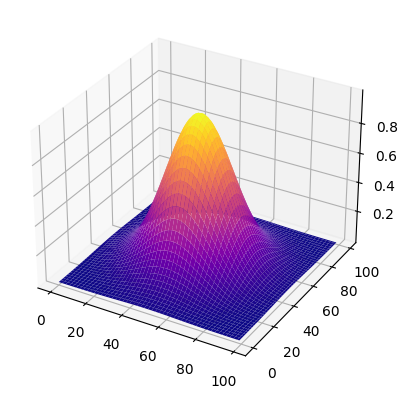

In [6]:
if not GAUSSIAN_IC:
    # Initialize the concentration field with random values
    c = torch.rand((1, 1, size, size), requires_grad=False)
else:
    # Initialize the concentration field with a 2D Gaussian centered at the middle of the domain
    x = np.linspace(-size//2, size//2, size)
    y = np.linspace(-size//2, size//2, size)
    x, y = np.meshgrid(x, y)
    sigma = size / 6  # Standard deviation of the Gaussian
    gaussian = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    c = torch.tensor(gaussian, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

advdif = AdvectionDiffusion(delta, delta_t, D, v_x, v_y)
    
# Create a meshgrid for plotting
X, Y = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Set up the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initial plot
surf = ax.plot_surface(X, Y, c.detach().numpy()[0, 0], cmap='plasma')

# Simulation function
def simulate(c, advdif, steps):
    for _ in range(steps):
        # Update the concentration field
        c = advdif(c)
    return c

# Animation update function
def update_plot(frame, c, surf, advdif):
    # Update the concentration field
    c = simulate(c, advdif, 1)  # Simulate one step
    ax.clear()
    # Update the surface plot
    surf = ax.plot_surface(X, Y, c.detach().numpy()[0, 0], cmap='plasma')
    return surf,

# Animate the simulation
ani = animation.FuncAnimation(fig, update_plot, fargs=(c, surf, advdif), frames=steps, interval=50, blit=False)

# Show the animation
# plt.show()

# To save the animation, you can use ani.save('simulation_3d.mp4')
ani.save('simulation_3d.mp4')